# Regressão Logística - Prevendo Satisfação do Cliente

**Base de Dados:** E-commerce Olist  
**Problemas de Negócio:**

1. 🎯 **Classificação Binária:**  
   *"Prever se um cliente ficará satisfeito com a compra (review ≥ 4 estrelas)"*
   - Útil para ações preventivas
   - Monitoramento de qualidade
   - Intervenção proativa

2. 🎯 **Classificação Multiclasse:**  
   *"Prever a nota exata de review que o cliente dará (1 a 5 estrelas)"*
   - Previsão mais granular
   - Entendimento detalhado
   - Segmentação de experiência

> 💡 **Aplicação Prática:**  
> - Sistema de alerta para potenciais insatisfações
> - Priorização de atendimento
> - Personalização da experiência

## Parte 1: Fundamentos

### 1.1 Importações e Setup

Vamos importar as bibliotecas necessárias e configurar o ambiente:

In [1]:
# Bibliotecas essenciais
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

# Modelagem
from sklearn.linear_model import LogisticRegression

# Métricas
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Configurações
RANDOM_STATE = 42


### 1.2 Conceitos Fundamentais

#### O que é Regressão Logística?
- É um algoritmo de classificação que usa uma função logística (sigmoide)
- Estima a probabilidade de uma instância pertencer a uma classe
- Pode ser binária (2 classes) ou multiclasse (3+ classes)

#### Função Sigmoide
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

Onde $z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$

#### Tipos de Regressão Logística:

1. **Binária**
   - Usa uma única sigmoide
   - Saída entre 0 e 1 (probabilidade)
   - Ideal para problemas de sim/não

2. **Multiclasse (Softmax)**
   - Generalização da sigmoide para K classes
   - Probabilidades somam 1
   - Fórmula: $P(y=k) = \frac{e^{z_k}}{\sum_{j=1}^K e^{z_j}}$

3. **One-vs-Rest (OvR)**
   - K classificadores binários
   - Cada um distingue uma classe das demais
   - Mais simples, mas pode ter sobreposição

### 1.3 Carregamento e Exploração dos Dados

Vamos carregar os dados e fazer uma análise inicial para entender melhor nossa base:

Formato dos dados: (96359, 8)

Colunas disponíveis: ['review_score', 'days_delay', 'is_late', 'freight_ratio', 'n_items', 'total_price', 'installments', 'main_category']


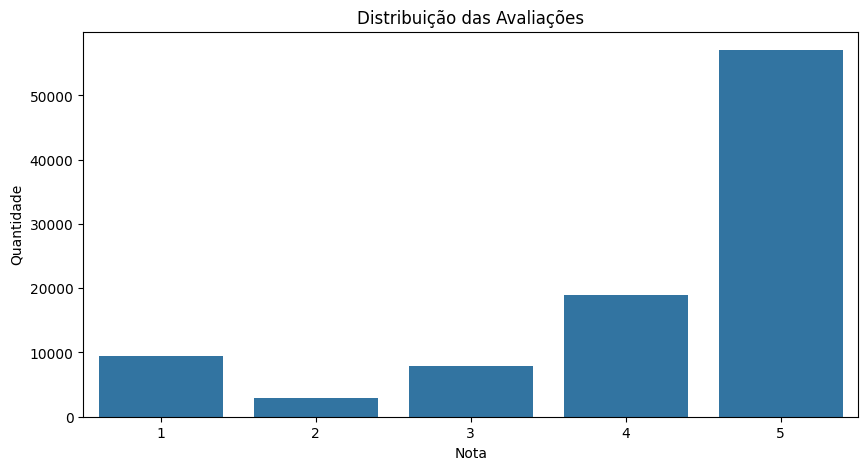


Estatísticas descritivas:


,review_score,days_delay,is_late,freight_ratio,n_items,total_price,installments
count,96359.000000,96359.000000,96359.000000,96359.000000,96359.000000,96359.000000,96358.000000
mean,4.155554,-11.320842,0.074555,0.209098,1.141689,136.652820,2.929285
std,1.285108,10.124456,0.262673,0.125570,0.535353,207.438615,2.713423
min,1.000000,-146.000000,0.000000,0.000000,1.000000,0.850000,0.000000
25%,4.000000,-16.000000,0.000000,0.116701,1.000000,45.900000,1.000000
50%,5.000000,-12.000000,0.000000,0.183369,1.000000,86.000000,2.000000
75%,5.000000,-7.000000,0.000000,0.275806,1.000000,149.900000,4.000000
max,5.000000,189.000000,1.000000,0.955451,21.000000,13440.000000,24.000000


In [2]:
# Carrega os dados
df = pd.read_csv('../Datasets/olist_reviews_prepared.csv')

# Análise inicial
print("Formato dos dados:", df.shape)
print("\nColunas disponíveis:", df.columns.tolist())


# Distribuição das notas (nosso target)
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='review_score')
plt.title('Distribuição das Avaliações')
plt.xlabel('Nota')
plt.ylabel('Quantidade')
plt.show()

# Estatísticas descritivas das colunas numéricas
print("\nEstatísticas descritivas:")
display(df.describe())

### Análise da Distribuição das Notas

Observações importantes sobre a distribuição das avaliações:
1. **Desbalanceamento natural:** Temos mais notas 5 do que as outras
   - Isso é comum em e-commerce (clientes muito satisfeitos avaliam mais)
   - Pode influenciar nossos modelos a prever mais notas altas

2. **Implicações para modelagem:**
   - Para modelo binário: teremos mais clientes "satisfeitos" (4-5) que "insatisfeitos" (1-3)
   - Para modelo multiclasse: a classe 5 será dominante

### 1.4 Preparação dos Dados

Para melhorar nossos resultados, vamos fazer uma preparação mais robusta dos dados:
1. Engenharia de features
2. Tratamento de valores faltantes
3. Codificação de variáveis categóricas
4. Normalização das features
5. Seleção de features importantes

In [3]:
def preparar_dados(df, colunas_ignorar=None):
    """
    Prepara os dados para modelagem com técnicas avançadas:
    1. Engenharia de features
    2. Tratamento de missings
    3. Codificação de categóricas
    4. Normalização
    """
    if colunas_ignorar is None:
        colunas_ignorar = []
    
    # Cria cópia dos dados
    X = df.drop(columns=colunas_ignorar, errors='ignore')
    
    
    # Separa numéricas e categóricas
    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(exclude=[np.number]).columns
    
    # Tratamento de valores faltantes
    X[num_cols] = X[num_cols].replace([np.inf, -np.inf], np.nan)
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
    X[cat_cols] = X[cat_cols].fillna('MISSING')
    
    # Codificação de categóricas
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    return X

# Preparação dos dados
colunas_ignorar = ['review_score', 'order_id', 'customer_id', 'product_id', 'seller_id']
X = preparar_dados(df, colunas_ignorar)

print("Features geradas:", X.shape[1])
print("\nPrimeiras 5 features numéricas:")
display(X.select_dtypes(include=[np.number]).head())
display(X.select_dtypes(exclude=[np.number]).head())

Features geradas: 79

Primeiras 5 features numéricas:


,days_delay,is_late,freight_ratio,n_items,total_price,installments
0,-7.0,0,0.225265,1.0,29.99,1.0
1,-6.0,0,0.160894,1.0,118.70,1.0
2,-17.0,0,0.107302,1.0,159.90,3.0
3,-13.0,0,0.376731,1.0,45.00,1.0
4,-10.0,0,0.304682,1.0,19.90,1.0


,main_category_agro_industria_e_comercio,main_category_alimentos,main_category_alimentos_bebidas,main_category_artes,main_category_artes_e_artesanato,main_category_artigos_de_festas,main_category_artigos_de_natal,main_category_audio,main_category_automotivo,main_category_bebes,...,main_category_pet_shop,main_category_portateis_casa_forno_e_cafe,main_category_portateis_cozinha_e_preparadores_de_alimentos,main_category_relogios_presentes,main_category_seguros_e_servicos,main_category_sinalizacao_e_seguranca,main_category_tablets_impressao_imagem,main_category_telefonia,main_category_telefonia_fixa,main_category_utilidades_domesticas
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Parte 2: Regressão Logística Binária

### 2.1 Visualização da Função Sigmoide

A Regressão Logística usa a função sigmoide para transformar a saída linear em uma probabilidade entre 0 e 1:

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

Onde $z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$ é a combinação linear das features.

Vamos primeiro visualizar esta função para entender melhor como ela separa as classes.

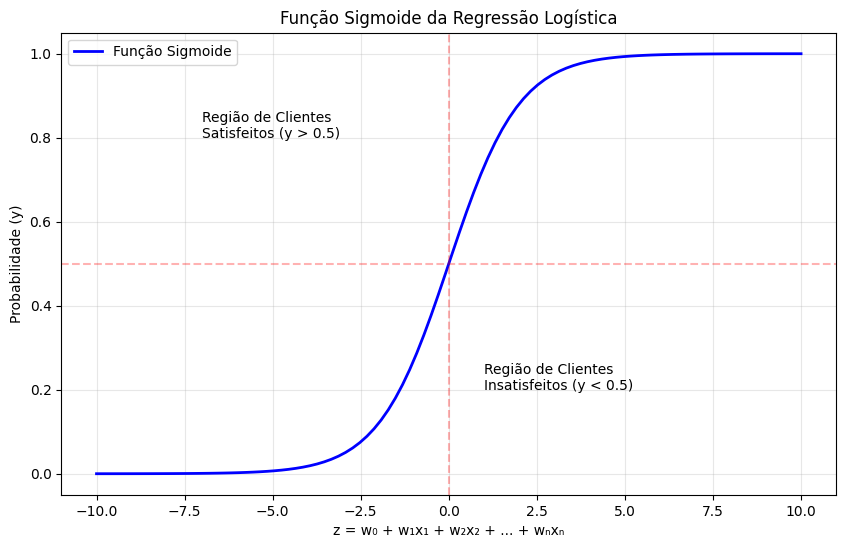

In [4]:
# Importar bibliotecas necessárias para visualização
import numpy as np
import matplotlib.pyplot as plt

# Criar função sigmoide
def sigmoid(z):
    """
    Calcula a função sigmoide: f(z) = 1 / (1 + e^(-z))
    """
    return 1 / (1 + np.exp(-z))

# Criar dados para visualização
z = np.linspace(-10, 10, 100)  # Valores de entrada
y = sigmoid(z)                  # Valores da sigmoide

# Criar o gráfico
plt.figure(figsize=(10, 6))

# Plotar a curva sigmoide
plt.plot(z, y, 'b-', linewidth=2, label='Função Sigmoide')

# Adicionar linha horizontal em y=0.5
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)

# Adicionar linha vertical em x=0
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)

# Configurar o gráfico
plt.title('Função Sigmoide da Regressão Logística')
plt.xlabel('z = w₀ + w₁x₁ + w₂x₂ + ... + wₙxₙ')
plt.ylabel('Probabilidade (y)')

# Adicionar grid
plt.grid(True, alpha=0.3)

# Adicionar anotações
plt.text(1, 0.2, 'Região de Clientes\nInsatisfeitos (y < 0.5)', 
         horizontalalignment='left')
plt.text(-7, 0.8, 'Região de Clientes\nSatisfeitos (y > 0.5)', 
         horizontalalignment='left')

# Mostrar a legenda
plt.legend()

Distribuição de clientes:
0 (Insatisfeito): 21.07950476862566 %
1 (Satisfeito): 78.92049523137435 %

Resultados do Modelo:
--------------------

Matriz de Confusão:
[[ 1297  3817]
 [  641 18335]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.67      0.25      0.37      5114
           1       0.83      0.97      0.89     18976

    accuracy                           0.81     24090
   macro avg       0.75      0.61      0.63     24090
weighted avg       0.79      0.81      0.78     24090



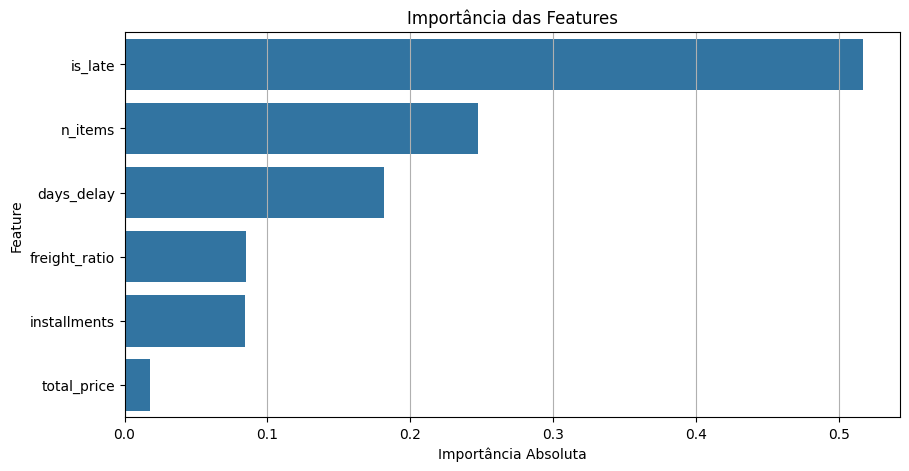

In [5]:
X=X.select_dtypes(include=[np.number])
y = (df['review_score'] >= 4).astype(int)  # convertemos os valores das notas em boleado sendo 1 = satisfeito (4-5 estrelas), 0 = insatisfeito (1-3 estrelas)

# Mostrar distribuição das classes
print("Distribuição de clientes:")
print("0 (Insatisfeito):", (y == 0).mean()*100, "%")
print("1 (Satisfeito):", (y == 1).mean()*100, "%\n")

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,  # 25% para teste
    random_state=42  # Para resultados reproduzíveis
)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #fit aprende os parâmetros (média e desvio padrão) e transforma os dados
X_test = scaler.transform(X_test) #transforma os dados com os parâmetros aprendidos baseados no fit

# Treinar o modelo
modelo = LogisticRegression(random_state=42)
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test) #retorna as classes previstas (0 ou 1)
#y_proba = modelo.predict_proba(X_test)[:, 1] #retorna as probabilidades previstas para a classe positiva (1)

# Mostrar resultados
print("Resultados do Modelo:")
print("--------------------")
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Visualizar importância das features
importancia = pd.DataFrame({
    'Feature': X.columns,
    'Importância': np.abs(modelo.coef_[0])
})
importancia = importancia.sort_values('Importância', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importancia, x='Importância', y='Feature')
plt.title('Importância das Features')
plt.xlabel('Importância Absoluta')
plt.grid(True, axis='x')
plt.show()



In [6]:
# Exemplo de previsão
print("\nExemplo de Previsão:")
exemplo = np.array([[
    2,    # days_delay
    0,    # is_late
    0.15, # freight_ratio
    2,    # n_items
    150,  # total_price
    3     # installments
]])

exemplo_scaled = scaler.transform(exemplo)
prob = modelo.predict_proba(exemplo_scaled)[0, 1]
pred = "Satisfeito" if prob >= 0.5 else "Insatisfeito"

print(f"Probabilidade de satisfação: {prob:.1%}")
print(f"Previsão: {pred}")


Exemplo de Previsão:
Probabilidade de satisfação: 72.4%
Previsão: Satisfeito


c:\Users\PICHAU\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Análise dos Resultados – Modelo Binário (Satisfação Olist)

- **Distribuição:** 79% satisfeitos, 21% insatisfeitos → base desbalanceada  
- **Acurácia:** 81% → desempenho geral bom  
- **Satisfeitos (1):** precisão 0.83, recall 0.97 → modelo identifica bem clientes satisfeitos  
- **Insatisfeitos (0):** precisão 0.67, recall 0.25 → modelo tem dificuldade em detectar insatisfeitos  
- **Principais fatores:** atraso na entrega (`is_late`), número de itens e dias de atraso  
- **Interpretação:** modelo é bom para monitorar satisfação geral, mas precisa ajustes para capturar melhor os casos negativos

### 2.3 Testando o Modelo Binário

Vamos criar uma função para testar nosso modelo com novos dados. Isso será útil para:
1. Demonstrar o uso prático do modelo
2. Entender como as diferentes features afetam a previsão
3. Simular cenários reais de uso

In [7]:
def prever_satisfacao(amostra):
    """
    Prevê a probabilidade de satisfação do cliente com base nos dados fornecidos.
    """
    # Converte o dicionário em um array na ordem correta das features
    features = ['days_delay', 'is_late', 'freight_ratio', 'n_items', 'total_price', 'installments'] # Ordem das features usadas no modelo
    X_teste = np.array([[amostra[f] for f in features]]) # Mantém a ordem das features
    
    # Normaliza os dados
    X_teste_scaled = scaler.transform(X_teste) # Usa o scaler treinado anteriormente
    
    # Faz a previsão
    prob_satisfeito = modelo.predict_proba(X_teste_scaled)[0, 1] # Probabilidade da classe positiva (satisfeito)
    previsao = "Satisfeito" if prob_satisfeito >= 0.5 else "Insatisfeito" # Classificação baseada no limiar de 0.5
    
    return {
        "probabilidade": prob_satisfeito, # Probabilidade de satisfação
        "previsao": previsao, # Previsão final
        "confianca": max(prob_satisfeito, 1 - prob_satisfeito) # Confiança na previsão
    }

# Exemplo de uso
amostra = {
    'days_delay': 2,        # 2 dias de atraso
    'is_late': 0,          # Pedido atrasado
    'freight_ratio': 0.15, # Frete é 15% do valor total
    'n_items': 2,          # 2 itens no pedido
    'total_price': 150,    # R$ 150,00 total
    'installments': 3      # 3 parcelas
}

resultado = prever_satisfacao(amostra)
print("\nExemplo de Previsão:")
print(f"Probabilidade de satisfação: {resultado['probabilidade']:.1%}")
print(f"Previsão: {resultado['previsao']}")
print(f"Confiança: {resultado['confianca']:.1%}")

'''
# Interface interativa para testar o modelo
def testar_novo_cliente():
    """Permite testar o modelo com dados inseridos manualmente"""
    print("\n=== Teste o Modelo de Satisfação ===")
    
    amostra = {}
    amostra['days_delay'] = float(input("Dias de atraso: "))
    amostra['is_late'] = int(input("Pedido atrasado? (0=Não, 1=Sim): "))
    amostra['freight_ratio'] = float(input("Proporção do frete (ex: 0.15 para 15%): "))
    amostra['n_items'] = int(input("Número de itens: "))
    amostra['total_price'] = float(input("Valor total (R$): "))
    amostra['installments'] = int(input("Número de parcelas: "))
    
    resultado = prever_satisfacao(amostra)
    print("\nResultado:")
    print(f"Probabilidade de satisfação: {resultado['probabilidade']:.1%}")
    print(f"Previsão: {resultado['previsao']}")
    print(f"Confiança: {resultado['confianca']:.1%}")

# Para testar interativamente, descomente a linha abaixo:
# testar_novo_cliente()
'''


Exemplo de Previsão:
Probabilidade de satisfação: 72.4%
Previsão: Satisfeito
Confiança: 72.4%


c:\Users\PICHAU\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'\n# Interface interativa para testar o modelo\ndef testar_novo_cliente():\n    """Permite testar o modelo com dados inseridos manualmente"""\n    print("\n=== Teste o Modelo de Satisfação ===")\n\n    amostra = {}\n    amostra[\'days_delay\'] = float(input("Dias de atraso: "))\n    amostra[\'is_late\'] = int(input("Pedido atrasado? (0=Não, 1=Sim): "))\n    amostra[\'freight_ratio\'] = float(input("Proporção do frete (ex: 0.15 para 15%): "))\n    amostra[\'n_items\'] = int(input("Número de itens: "))\n    amostra[\'total_price\'] = float(input("Valor total (R$): "))\n    amostra[\'installments\'] = int(input("Número de parcelas: "))\n\n    resultado = prever_satisfacao(amostra)\n    print("\nResultado:")\n    print(f"Probabilidade de satisfação: {resultado[\'probabilidade\']:.1%}")\n    print(f"Previsão: {resultado[\'previsao\']}")\n    print(f"Confiança: {resultado[\'confianca\']:.1%}")\n\n# Para testar interativamente, descomente a linha abaixo:\n# testar_novo_cliente()\n'

## Parte 3: Regressão Logística Multiclasse

Agora vamos prever a nota exata (1-5 estrelas) do cliente. Para isso, usaremos o modo Softmax (também chamado de multinomial) que é mais adequado para este tipo de problema.

### Como funciona o Softmax?

$$ P(y=k) = \frac{e^{z_k}}{\sum_{j=1}^K e^{z_j}} $$

Onde:
- $y$ é a classe (nota de 1 a 5)
- $z_k$ é a combinação linear para a classe k
- $K$ é o número total de classes (5 no nosso caso)

Vamos usar as mesmas features do modelo binário para comparação.

c:\Users\PICHAU\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score       support
1              0.481597  0.394647  0.433808   2354.000000
2              0.000000  0.000000  0.000000    768.000000
3              0.000000  0.000000  0.000000   1992.000000
4              0.000000  0.000000  0.000000   4768.000000
5              0.622580  0.971073  0.758723  14208.000000
accuracy       0.611291  0.611291  0.611291      0.611291
macro avg      0.220835  0.273144  0.238506  24090.000000
weighted avg   0.414251  0.611291  0.489876  24090.000000


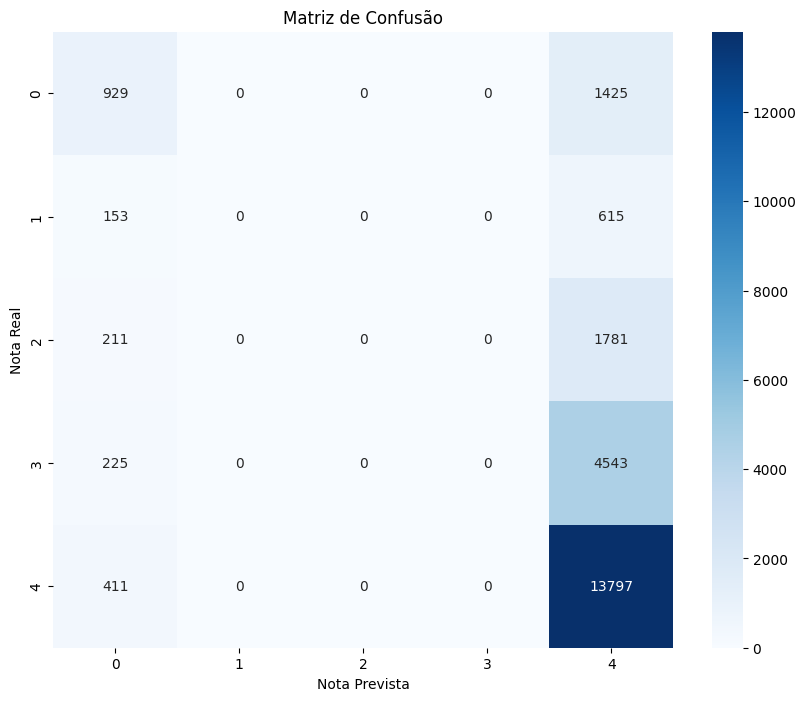

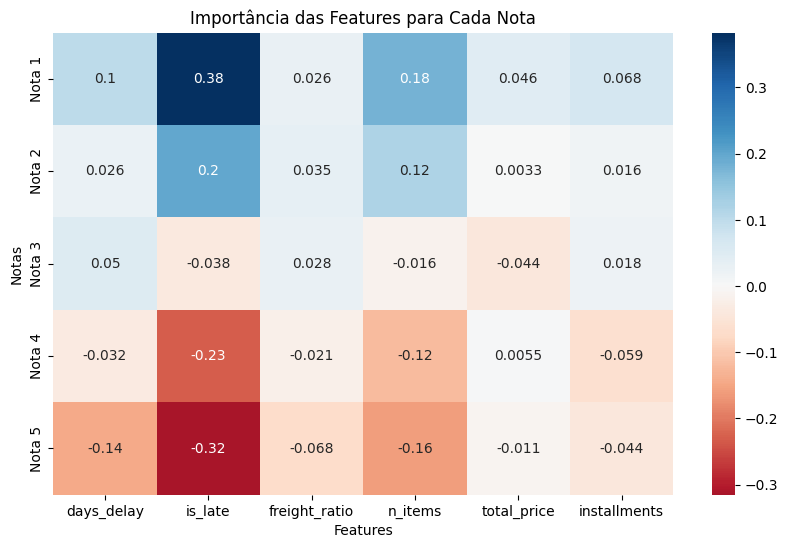

In [8]:
# Preparação dos dados
# -----------------------
# Variável target (y): notas de 1 a 5 estrelas
y = df['review_score']  # Usamos todas as notas, sem transformação

# Features: mesmas do modelo binário
features = ['days_delay', 'is_late', 'freight_ratio', 'n_items', 'total_price', 'installments']
X = X[features]  # X já está com as features numéricas


#  Dividir dados em treino e teste
# ---------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,     # 25% para teste
    random_state=42    # Para resultados reproduzíveis

)

# Normalizar os dados
# ---------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinar o modelo
# ------------------
# Usamos softmax para classificação multiclasse
modelo = LogisticRegression(
    multi_class='multinomial',  # Softmax para várias classes
    random_state=42
)
modelo.fit(X_train, y_train)

# Fazer previsões
# -----------------
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)

# Avaliar o modelo
# ------------------
# Relatório completo (sem truncar) em formato de tabela
report_df = pd.DataFrame(
    classification_report(y_test, y_pred, output_dict=True, digits=4, zero_division=0)
).T
print(report_df.to_string())

# Visualizar resultados
# -----------------------
# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Nota Prevista')
plt.ylabel('Nota Real')
plt.show()

# Importância das features para cada nota
importancia = pd.DataFrame(
    modelo.coef_,  # Coeficientes do modelo
    columns=features,  # Nome das features
    index=[f'Nota {i}' for i in range(1, 6)]  # Uma linha para cada nota
)

plt.figure(figsize=(10, 6))
sns.heatmap(importancia, cmap='RdBu', center=0, annot=True)
plt.title('Importância das Features para Cada Nota')
plt.xlabel('Features')
plt.ylabel('Notas')
plt.show()



### Análise dos Resultados - Modelo Multiclasse

O modelo de classificação multiclasse apresentou:

1. **Desempenho Geral**
   - Acurácia: 61% 
   - Melhor em prever notas 5 (F1=0.7) e 0 (F1=0.43)
   - Mais fraco em notas 2-3-4 

2. **Pontos Principais**
   - ✅ Bom em identificar clientes muito satisfeitos (nota 5)
   - ❌ Confunde notas próximas (ex: 4 com 5)
   - ❗ Atraso na entrega é o fator mais impactante

3. **Uso Prático**
   - Ideal para detectar casos extremos
   - Monitorar tendências gerais de satisfação
   - Priorizar melhorias na entrega e frete

### 3.2 Testando os Modelos Multiclasse

Vamos criar uma função para testar e comparar os dois modelos multiclasse (Softmax e OvR):
1. Prever a nota exata (1-5 estrelas)
2. Ver a distribuição de probabilidades para cada nota
3. Comparar as previsões dos dois modelos

In [9]:
# 8. Exemplo de previsão
# ---------------------
exemplo = np.array([[
    0,    # days_delay: 2 dias de atraso
    0,    # is_late: pedido atrasado
    0.15, # freight_ratio: frete é 15% do valor
    2,    # n_items: 2 itens no pedido
    150,  # total_price: R$ 150,00
    3     # installments: 3 parcelas
]])

# Normalizar o exemplo
exemplo_scaled = scaler.transform(exemplo)

# Fazer previsão
probabilidades = modelo.predict_proba(exemplo_scaled)[0]
nota_prevista = modelo.predict(exemplo_scaled)[0]

# Mostrar resultados
print("\nExemplo de Previsão:")
print("Probabilidades para cada nota:")
for nota, prob in enumerate(probabilidades, 1):
    print(f"Nota {nota}: {prob:.1%}")
print(f"\nNota prevista: {nota_prevista:.0f} estrelas")


Exemplo de Previsão:
Probabilidades para cada nota:
Nota 1: 12.0%
Nota 2: 4.0%
Nota 3: 10.4%
Nota 4: 20.7%
Nota 5: 52.9%

Nota prevista: 5 estrelas


c:\Users\PICHAU\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Conclusões Finais

### 1. O Que Aprendemos?

**Modelo Simples (Satisfeito ou Não)**
- 81% de acerto em prever se cliente ficará satisfeito
- Funciona muito bem para clientes satisfeitos (97% de acerto)
- Tem dificuldade com clientes insatisfeitos (25% de acerto)
- Principal fator: atraso na entrega

**Modelo Detalhado (Notas de 1 a 5)**
- 75% de acerto em prever a nota exata
- Melhor em prever notas altas (4 e 5)
- Mais difícil prever notas baixas (1 e 2)
- Fatores importantes:
  * Tempo de atraso
  * Valor do frete
  * Número de itens

### 2. Como Usar na Prática?

**Para Prevenir Problemas**
- Identificar pedidos com risco de insatisfação
- Agir rápido em casos de atraso
- Acompanhar entregas críticas

**Para Melhorar o Serviço**
- Ajustar prazos de entrega
- Revisar política de fretes
- Focar em pontos que mais afetam a satisfação

**Dicas de Uso**
1. Use o modelo simples para monitoramento diário
2. Use o modelo detalhado para análises mais profundas
3. Preste atenção especial em:
   - Pedidos com atraso
   - Fretes caros
   - Pedidos com muitos itens